# Case Study 1 : Yelp Data Analysis

**Required Readings:** 
* [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge) 
* Please download the Yelp dataset from the above webpage.

**NOTE**
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.


Here is an example of the data format. More details are included [here](https://www.yelp.com/dataset_challenge)

## Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
## Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In [ ]:
# The problem being solved is from a business perspective. We are attempting to solve the problem of 
# Receiving a bad review by identifying which phrases are most common in one star reviews from accounts 
# with only one review. We want to know what events occure that cause a patron to be so upset with a 
# business that they make a Yelp account just to leave a one star review?

# Data Collection/Processing: 

In [ ]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Data Exploration: Exploring the Yelp Dataset

**(1) Finding the most popular business categories:** 
* print the top 10 most popular business categories in the dataset and their counts (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').

In [ ]:
# Import relevant libraries
import numpy as np
import pandas as pd
from collections import Counter
# Load Yelp's buisness data
data = pd.read_csv('data/business.csv', encoding='latin1')
# Add a comma to the end of every list of categories
data['categories'] = data['categories'].map(lambda x: str(x)+',')
# Concatinate all the lists of categories into one big list
big_list = ''.join(data['categories'])
# Remove spaces from the big list
big_list = big_list.replace(' ','')
# Fix double commas in the big list
big_list = big_list.replace(',,',',')
# Split the categories into a list of categories as they occure
big_list = big_list.split(',')
# Count the occurance of every category
counted_categories = Counter(big_list)
# Print the 10 most common categories
print(np.array(counted_categories.most_common(10)))

** (2) Find the most popular business objects** 
* print the top 10 most popular business objects in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

In [ ]:
# Import relevant libraries
import pandas as pd
from collections import Counter
# Load Yelp's buisness and checkin data
buisness_data = pd.read_csv('data/business.csv', encoding='latin1')
checkin_data = pd.read_csv('data/checkin.csv', encoding='latin1')
# Count how many checkins each buisness has
checkin_data['count'] = checkin_data['date'].map(lambda x: str(x).count(',')+1)
# Drop irrelevant columns
checkin_data.drop(['date','Unnamed: 0'],axis=1,inplace=True)
# Sort the buisnesses by their checkin count
checkin_data.sort_values(['count'],ascending=False,inplace=True)
# Display the first 10 buisness IDs and counts
print(checkin_data.head(10).values)

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In [ ]:
# We will plot the distribution of unique, tokenized, lemmitized one star reviews
# from accounts with one review and assume that the most common phrases are the events
# that businesses need to try the most to avoid.

Write codes to implement the solution in python:

In [1]:
# Load in the parsed data and isolate only the one star reviews with at least one useful vote
# left by users with only one review.

import pandas as pd

review_data = pd.read_csv('data/parsed_review.csv', encoding='latin1', engine='python', error_bad_lines=False)
user_data = pd.read_csv('data/parsed_user.csv', encoding='latin1', engine='python', error_bad_lines=False)
sole_useful_bad_reviews = pd.merge(user_data, review_data, on='user_id', how='outer')
sole_useful_bad_reviews = sole_useful_bad_reviews.drop(['Unnamed: 0_x','Unnamed: 0_y',],axis=1)
sole_useful_bad_reviews = sole_useful_bad_reviews.drop(sole_useful_bad_reviews[sole_useful_bad_reviews['useful'] == 0].index)

user_id        568565
business_id    568564
useful         568564
text           568563
dtype: int64


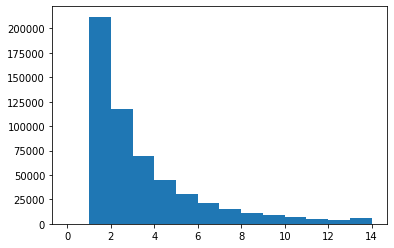

user_id        238856
business_id    238855
useful         238855
text           238854
dtype: int64


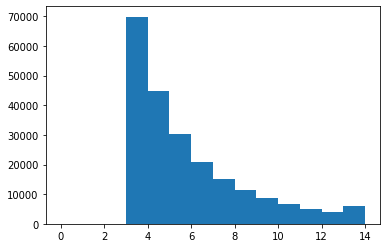

In [3]:
# Look at the distribution of useful

import matplotlib.pyplot as plt

print(sole_useful_bad_reviews.count())
plt.hist(sole_useful_bad_reviews['useful'],list(range(15)))
plt.show()

sole_very_useful_bad_reviews = sole_useful_bad_reviews.drop(sole_useful_bad_reviews[sole_useful_bad_reviews['useful'] < 5].index)
print(sole_very_useful_bad_reviews.count())
plt.hist(sole_very_useful_bad_reviews['useful'],list(range(15)))
plt.show()

In [4]:
# Convert all the reviews into a big list of sentences

from nltk.tokenize import sent_tokenize

reviews = ''.join(sole_very_useful_bad_reviews['text'].map(lambda x: str(x)))
reviews = sent_tokenize(reviews)

In [5]:
print(len(reviews))

2795608


In [8]:
# Use Facebook's InferSent sentence embedding method to generate embeddings of all the review sentences
# https://github.com/facebookresearch/InferSent

from InferSent.models import InferSent
import torch

MODEL_PATH = "encoder/infersent%s.pkl"
model = InferSent({'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': 2})
model.load_state_dict(torch.load('encoder/infersent2.pkl'))
#model = model.cuda()
model.set_w2v_path('fastText/crawl-300d-2M.vec')
model.build_vocab_k_words(K=100000)
embeddings = model.encode(reviews, bsize=128, tokenize=False, verbose=True)

Vocab size : 100000
Nb words kept : 47733193/53028829 (90.0%)


KeyboardInterrupt: 

In [ ]:
print(reviews[:3])
print(embeddings[:3])

In [ ]:
df = pd.df({'sentence': reviews, 'embedding': embeddings})
df.to_csv('review_sentece_embeddings.csv')

In [ ]:
# Use agglomerative clustering to form groups of sentences with similar meanings

import numpy as np
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=None, affinity='cosine', compute_full_tree=True, linkage='ward' , distance_threshold=0.2)
membership = ac.fit_predict(embeddings)

print(np.unique(membership))
test_reviews = reviews[membership==1]
print(test_reviews[:,10])

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
reviews = ''.join(sole_useful_bad_reviews['text'].map(lambda x: str(x)))
reviews = sent_tokenize(reviews)

stop_words = set(stopwords.words("english"))

filtered_reviews = []
for r in reviews:
    if r not in stop_words:
        filtered_reviews.append(r)

lem = WordNetLemmatizer()
lemmitized_reviews = []
for r in filtered_reviews:
    lemmitized_reviews.append(lem.lemmatize(r))
    
print(lemmitized_reviews[:5])
print(reviews[:5])
fd = FreqDist(lemmitized_reviews)
fd.plot(10,cumulative=False)
plt.show()

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [ ]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary








*-----------------
# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 7 minutes' talk) to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


**How to submit:**

        Please submit through Canvas, in the Assignment "Case Study 1".
        
**Note: Each team only needs to submit one submission in Canvas**


# Peer-Review Grading Template:

**Total Points: (100 points)** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) Finding the most popular business categories (5 points):
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    (2) Find the most popular business objects (5 points)
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        


